# **Retrieval Augmented Generation (RAG) 애플리케이션 구축: Part 1**

LLM(대규모 언어 모델)에 의해 가능해진 가장 강력한 애플리케이션 중 하나는 **정교한 질문-답변(Q&A) 챗봇**입니다. 이러한 애플리케이션은 특정 출처 정보를 기반으로 질문에 답할 수 있습니다. 이 기술은 **Retrieval Augmented Generation (RAG)**이라고 불립니다.
  
이 노트북에서는 **텍스트 데이터 소스**를 기반으로 간단한 Q&A 애플리케이션을 구축하는 방법을 다룰 것입니다. 진행하면서 전형적인 Q&A 아키텍처를 설명하고, 고급 Q&A 기술을 위한 추가 자료를 강조할 것입니다. 또한 **LangSmith**가 애플리케이션을 추적하고 이해하는 데 어떻게 도움을 줄 수 있는지 살펴볼 것입니다. 애플리케이션이 복잡해질수록 LangSmith의 도움은 더욱 중요해질 것입니다.  

이 노트북은 **비정형 데이터(unstructured data)**에 대한 Q&A에 초점을 맞추고 있습니다.

---

## 전형적인 **RAG 애플리케이션**

두 가지 주요 구성 요소로 이루어져 있습니다:  

1. **인덱싱(Indexing)**: 데이터 소스를 수집하고 인덱싱하는 파이프라인입니다. *일반적으로 오프라인에서 수행됩니다.*  
2. **검색 및 생성(Retrieval and Generation)**: 실행 시간에 사용자 쿼리를 받아 인덱스에서 관련 데이터를 검색한 후, 모델에 전달하여 답변을 생성합니다.  

---

### **인덱싱 단계**  
일반적인 데이터 인덱싱 과정은 다음과 같습니다:  

1. **로드(Load)**  
   - 먼저 데이터를 불러와야 합니다. 이는 문서 로더(Document Loaders)를 사용하여 수행됩니다.  

2. **분할(Split)**  
   - 텍스트 분할기(Text Splitters)를 사용해 큰 `문서(Document)`를 작은 청크(chunk)로 나눕니다.  
   - 이렇게 하면 검색이 더 효율적이며, 모델의 제한된 컨텍스트 윈도우에 맞출 수 있습니다.  

3. **저장(Store)**  
   - 분할된 데이터를 저장하고 인덱싱할 장소가 필요합니다.  
   - 일반적으로 벡터 스토어(VectorStore)와 임베딩 모델(Embeddings)을 사용합니다.  

![index_diagram](https://github.com/langchain-ai/langchain/blob/master/docs/static/img/rag_indexing.png?raw=1)

---

### **검색 및 생성 단계**  
일반적인 검색 및 생성 과정은 다음과 같습니다:  

4. **검색(Retrieve)**  
   - 사용자 입력을 받아 검색기(Retriever)를 사용하여 저장된 데이터에서 관련 청크를 검색합니다.  

5. **생성(Generate)**  
   - 챗 모델(ChatModel) 또는 LLM이 검색된 데이터를 포함한 프롬프트를 사용해 답변을 생성합니다.  

![retrieval_diagram](https://github.com/langchain-ai/langchain/blob/master/docs/static/img/rag_retrieval_generation.png?raw=1)

---

인덱싱이 완료된 후에는 LangGraph를 오케스트레이션 프레임워크로 사용하여 **검색 및 생성 단계**를 구현합니다.

In [1]:
# !pip install -qU \
# python-dotenv \
# langchain \
# langchain-community \
# openai \
# anthropic \
# langchain-openai \
# langchain-anthropic \
# langchain-google-genai \
# python-dotenv

# !pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph langchainhub tiktoken

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
# LangChain 추적(Tracing) 설정 활성화
os.environ["LANGCHAIN_TRACING_V2"] = "true"

In [4]:
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings

# 사용할 언어 모델의 이름을 지정
llm = ChatOpenAI(model="gpt-4o-mini")
# 사용할 임베딩 모델의 이름을 지정
embeddings = OpenAIEmbeddings(model='text-embedding-3-small')

In [5]:
# InMemoryVectorStore - 메모리 내에서 벡터 데이터를 저장 및 빠른 검색
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

이  노트북에서는 **웹사이트 콘텐츠에 대한 질문에 답변하는 애플리케이션**을 구축합니다.  
사용할 웹사이트는 **[LLM Powered Autonomous Agents](https://lilianweng.github.io/posts/2023-06-23-agent/)**라는 **Lilian Weng**의 블로그 포스트입니다.  
이 애플리케이션을 통해 블로그 게시물의 내용을 바탕으로 질문에 답할 수 있습니다.  

우리는 약 **50줄의 코드**로 간단한 **인덱싱 파이프라인**과 **RAG 체인**을 만들 수 있습니다.   
**텍스트를 로드, 분할, 인덱싱**한 후, **사용자 질문을 기반으로 관련 데이터를 검색**하고 답변을 생성합니다.

## **단계별 상세 설명**

## **1. 인덱싱 {#indexing}**

### **문서 불러오기 (Loading documents)**

먼저 블로그 게시물의 내용을 불러와야 합니다. 이를 위해 **Document Loaders**를 사용할 수 있습니다.  이 객체는 데이터 소스에서 정보를 불러와 **Document** 객체 목록으로 반환합니다.  

이 경우, **[WebBaseLoader](https://python.langchain.com/docs/integrations/document_loaders/web_base/)**를 사용합니다.  
- `WebBaseLoader`는 `urllib`를 사용해 **웹 URL에서 HTML을 로드**합니다.  
- 이후, `BeautifulSoup`을 사용해 **텍스트로 파싱**합니다.  

#### **HTML → 텍스트 변환 커스터마이징**  
- `bs_kwargs` 매개변수를 사용하여 `BeautifulSoup` 파서에 사용자 정의 옵션을 전달할 수 있습니다.  

In [28]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# HTML에서 `post-content`, `post-title`, `post-header` 클래스를 가진 콘텐츠만 추출하여 텍스트 변환
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))

# WebBaseLoader를 사용해 웹 페이지의 내용을 불러옵니다.
# Define the headers with a User-Agent
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer}
)

# 문서 로드하여 Document 객체 목록 반환
docs = loader.load()

# 로드된 문서가 정확히 하나인지 검증합니다.
assert len(docs) == 1

# 문서의 총 문자 수 출력
print(f"Total characters: {len(docs[0].page_content)}")

Total characters: 43130


In [7]:
# 문서 길이
print(len(docs[0].page_content))
# 첫번째 500 자 출력
print(docs[0].page_content[:500])

43130


      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In



---

### **문서 분할 (Splitting documents)**  

불러온 문서는 **42,000자 이상**으로, 많은 언어 모델의 **컨텍스트 윈도우(context window)**에 넣기에는 너무 길므로, 너무 긴 입력은 **정보를 효과적으로 찾아내기 어려울 수 있습니다.**  

이 문제를 해결하기 위해, **`Document`를 작은 청크(chunk)로 분할**하여 **임베딩(embedding)** 및 **벡터 저장(vector storage)**에 사용합니다.  
이렇게 하면 블로그 게시물의 **가장 관련성 높은 부분만 검색**할 수 있습니다.  

---

**RecursiveCharacterTextSplitter**는 문서를 **공통 구분자(예: 줄바꿈)**를 사용해 재귀적으로 분할합니다.  일반적인 텍스트 사용 사례에 가장 적합한 텍스트 분할기입니다.




In [8]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,            # 각 청크의 최대 문자 수 (1,000자)
    chunk_overlap=200,          # 청크 간 겹치는 문자 수 (200자)
    add_start_index=True,       # 원본 문서에서 각 청크의 시작 인덱스를 추적
)

# 불러온 문서를 설정한 기준에 따라 청크로 분할
all_splits = text_splitter.split_documents(docs)

# 분할된 청크(서브 문서)의 개수 출력
print(f"블로그 글을 {len(all_splits)}개의 하위 문서로 분할했습니다.")

블로그 글을 66개의 하위 문서로 분할했습니다.


### **문서 저장 (Storing documents)**

이제 분할된 **66개의 텍스트 청크**를 인덱싱해야 합니다. 이를 통해 검색할 수 있습니다.  

1. 각 **문서 청크**의 내용을 **임베딩(embedding)** 합니다.
2. 이 **임베딩을 벡터 스토어(Vector Store)**에 삽입합니다.


In [9]:
# 분할된 문서 청크(all_splits)는 임베딩되어 벡터 스토어에 저장됩니다.
# 반환값은 저장된 각 문서 청크의 고유 ID 목록입니다.
document_ids = vector_store.add_documents(documents=all_splits)

# 첫 세 개의 문서 ID를 출력합니다.
print(document_ids[:3])

['7918a249-3578-462b-a9dd-60855a891a27', 'd0c98964-554b-4e13-b1d1-53bbdb382d4c', '407fa5b1-5927-4dab-b9bf-a0de5b0e6d28']


이로써 **인덱싱(Indexing)** 단계가 완료되었습니다!

- 이제 우리는 **질의 가능한 벡터 스토어**를 보유하고 있습니다.  
- 블로그 게시물의 청크가 저장되어 있으며, 사용자 질문을 받으면 **관련 청크를 반환**할 수 있습니다.  

---

## **2. 검색 및 생성 (Retrieval and Generation)**

이제 실제 **애플리케이션 로직(application logic)**을 작성해 보겠습니다.  
간단한 애플리케이션을 만들어 다음과 같은 작업을 수행할 것입니다:  

1. **사용자 질문을 입력받기**  
2. **질문과 관련된 문서 청크 검색**  
3. **검색된 문서와 질문을 모델에 전달**  
4. **모델이 답변을 생성**  

---

- 생성 단계에서는 **챗 모델(Chat Model)**을 사용할 것입니다.  
- RAG용 프롬프트는 LangChain의 **프롬프트 허브(prompt hub)**에 저장되어 있습니다.  

---

### **프로세스 요약**  
1. **사용자 질문 입력 → 문서 검색 → 답변 생성**  
2. 관련 문서를 검색하고 질문과 함께 모델에 전달  
3. 모델이 **최종 답변**을 생성  


In [10]:
from langchain import hub

# RAG에 최적화된 프롬프트를 LangChain Hub에서 가져옵니다.
prompt = hub.pull("rlm/rag-prompt")

# 프롬프트를 사용해 예제 메시지를 생성합니다.
example_messages = prompt.invoke(
    {"context": "(검색된 문서 내용이 여기 들어갑니다.)",
     "question": "(사용자의 질문이 여기 들어갑니다.)"}
).to_messages()

# 프롬프트로부터 생성된 메시지가 하나인지 확인
assert len(example_messages) == 1

# 첫 번째 메시지의 내용을 출력
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (사용자의 질문이 여기 들어갑니다.) 
Context: (검색된 문서 내용이 여기 들어갑니다.) 
Answer:


**LangGraph**를 사용하여 **검색(Retrieval)** 과 **생성(Generation)** 단계를 하나의 애플리케이션으로 통합할 것입니다. 이를 통해 다음과 같은 이점을 얻을 수 있습니다:

- **다양한 호출 모드 지원:**  
  한 번 정의된 애플리케이션 로직은 **스트리밍(streaming)**, **비동기(async)**, **배치 호출(batched calls)** 등 여러 호출 모드를 자동으로 지원합니다.

- **간편한 배포:**  
  [**LangGraph 플랫폼**](https://langchain-ai.github.io/langgraph/concepts/langgraph_platform/)을 통해 애플리케이션을 더 쉽게 배포할 수 있습니다.

- **자동 추적:**  
  **LangSmith**가 애플리케이션의 모든 단계를 자동으로 추적합니다.

- **확장성:**  
  [**데이터 지속성(persistence)**](https://langchain-ai.github.io/langgraph/concepts/persistence/) 및 [**사람의 승인(Human-in-the-loop approval)**](https://langchain-ai.github.io/langgraph/concepts/human_in_the_loop/)과 같은 핵심 기능을 최소한의 코드 변경으로 손쉽게 추가할 수 있습니다.

---

## **LangGraph를 사용하기 위한 3가지 핵심 요소**

1. **애플리케이션의 상태(State)**  
2. **애플리케이션의 노드(Nodes)** - 각 단계의 로직  
3. **애플리케이션의 흐름(Control Flow)** - 예) 단계의 순서 및 실행 흐름

---

### **1. 상태(State)**

애플리케이션의 [**상태(state)**](https://langchain-ai.github.io/langgraph/concepts/low_level/#state)는 다음을 관리합니다:  
- 애플리케이션에 입력되는 데이터  
- 각 단계 간에 전달되는 데이터  
- 애플리케이션에서 최종적으로 출력되는 데이터  

**상태(State)** 는 일반적으로 `TypedDict`로 정의하지만, 더 정교한 검증과 유연성이 필요하다면 [Pydantic BaseModel](https://langchain-ai.github.io/langgraph/how-tos/state-model/)을 사용할 수 있습니다.
- TypedDict: 간단하게 상태의 구조(예: 어떤 데이터가 어떤 형태로 들어와야 하는지)를 정의할 때 사용  
- Pydantic BaseModel: 더 복잡한 데이터 검증, 기본값 설정, 사용자 정의 검증 등을 할 때 사용

---

### **간단한 RAG 애플리케이션 상태 예시**

간단한 **RAG 애플리케이션**에서는 다음 항목만 추적하면 됩니다:  
1. **입력 질문(question)**  
2. **검색된 문맥(retrieved context)**  
3. **생성된 답변(generated answer)**  

다음 단계에서는 **노드(Nodes)** 를 정의하여 각 애플리케이션 단계를 설정하는 방법을 살펴보겠습니다!

In [11]:
from langchain_core.documents import Document

# List: 여러 Document 객체를 리스트로 저장할 때 사용
# TypedDict: 상태(State) 객체 정의를 위한 구조체 역할
from typing import List
from typing_extensions import TypedDict

# 애플리케이션의 상태(State) 객체 정의
class State(TypedDict):
    question: str          # 사용자 질문을 저장하는 문자열 필드`
    context: List[Document]    # 검색된 문서 목록을 저장하는 필드
    answer: str           # 생성된 답변을 저장하는 문자열 필드

#### **노드 (애플리케이션 단계)**

간단한 두 단계로 구성된 시퀀스를 정의해 보겠습니다:  

1. **검색 (Retrieval)**  
2. **생성 (Generation)**  

In [12]:
# 사용자의 질문을 기반으로 벡터 스토어에서 관련 문서를 검색
def retrieve(state: State):
    # 벡터 스토어에서 질문과 유사도가 높은 문서를 검색
    retrieved_docs = vector_store.similarity_search(state['question'])
    return {"context": retrieved_docs}
    
# 검색된 문서와 질문을 기반으로 모델이 답변을 생성
def generate(state: State):
    # 검색된 문서(context) 내용을 하나의 문자열로 합칩니다.
    combined_context = "\n\n".join(doc.page_content for doc in state['context'])
    
    # 프롬프트에 질문과 문서 내용을 전달하여 모델 입력 메시지 생성
    messages = prompt.invoke({"context": combined_context, "question": state["question"]})
    
    # LLM(대규모 언어 모델)에 메시지를 전달하여 답변 생성
    response = llm.invoke(messages)
    return {"answer": response.content}

애플리케이션을 하나의 **`graph` 객체**로 컴파일합니다.  여기서는 **검색 단계**와 **생성 단계**를 **단일 시퀀스(sequence)**로 연결합니다.

In [13]:
from langgraph.graph import START, StateGraph

# StateGraph 초기화
workflow = StateGraph(State)

# 검색(retrieve)과 생성(generate) 단계를 순차적으로 실행하도록 설정 (node 자동 추가)
workflow.add_sequence([retrieve, generate])

# 그래프의 시작점(START)을 'retrieve' 단계와 연결
workflow.add_edge(START, "retrieve")

# 그래프를 컴파일하여 최종 그래프 객체를 생성
app = workflow.compile()

**LangGraph**는 애플리케이션의 **흐름 제어(Control Flow)** 를 시각화

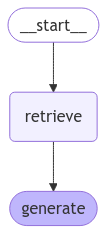

In [14]:
from IPython.display import Image, display

# 그래프의 흐름을 Mermaid 형식으로 시각화한 이미지를 표시합니다.
# - get_graph(): 그래프 객체를 가져옵니다.
# - draw_mermaid_png(): Mermaid 다이어그램을 PNG 이미지로 렌더링합니다.
display(Image(app.get_graph().draw_mermaid_png()))

**LangGraph**는 RAG 애플리케이션을 구축하는 데 반드시 필요하지는 않습니다. 실제로 개별 구성 요소를 사용하여 동일한 애플리케이션 로직을 구현할 수도 있습니다. 
그럼에도 LangGraph를 사용하는 이유는 복잡한 워크플로우 관리, 상태 관리 및 공유, 에이전트 간 협업 강화, 유연성과 확장성 때문 입니다.  

In [15]:
prompt = hub.pull("rlm/rag-prompt")

question = "Task Decomposition이 뭔가요? 한국어로 답해주세요."

retrieved_docs = vector_store.similarity_search(question)
docs_content = "\n\n".join(doc.page_content for doc in retrieved_docs)
message = prompt.invoke({"question": question, "context": docs_content}).to_messages()
answer = llm.invoke(message)
print(answer.content)

Task Decomposition은 복잡한 작업을 여러 단계로 나누어 더 작은 작업으로 변환하는 과정입니다. 이 방법은 모델이 각 단계에서 여러 사고를 생성하도록 하여 문제 해결을 용이하게 합니다. 따라서, Task Decomposition은 복잡한 문제를 관리 가능한 여러 작업으로 나누는 역할을 합니다.




**LangGraph의 주요 장점은 다음과 같습니다:**  

- **다양한 호출 모드 지원:**  
  - 출력 토큰을 스트리밍하거나 각 단계의 결과를 스트리밍하려면 위의 로직을 다시 작성해야 합니다.  
  - LangGraph는 이러한 호출 모드를 기본적으로 지원합니다.  
<p></p>
- **자동 추적 및 배포 지원:**  
  - **LangSmith**를 통해 애플리케이션 단계를 자동으로 추적합니다.  
  - [**LangGraph 플랫폼**](https://langchain-ai.github.io/langgraph/concepts/langgraph_platform/)을 통해 손쉽게 배포할 수 있습니다.  
<p></p>
- **지속성, 인간 개입(Human-in-the-loop) 지원:**  
  - LangGraph는 지속성(persistence) 및 인간 개입(human-in-the-loop) 기능을 기본적으로 지원합니다.  

---

많은 사용 사례에서는 RAG가 **대화형 경험(conversational experience)** 속에서 사용됩니다.  
즉, 사용자는 **상태(State)를 유지하면서 문맥이 반영된 답변**을 받을 수 있어야 합니다.    
 LangGraph의 **상태 관리(state management)** 및 **지속성(persistence)** 은 이러한 애플리케이션을 훨씬 더 쉽게 구현할 수 있도록 돕습니다.  

**LangGraph**는 다양한 호출 모드(**동기(sync)**, **비동기(async)**, **스트리밍(streaming)**)를 지원합니다.  

---

### **호출 (Invoke)**  

In [16]:
# 그래프를 호출하여 사용자 질문에 대한 답변을 생성
result = app.invoke({"question": "Task Decomposition이 뭔가요? 한국어로 답해주세요."})

# 검색된 문서(Context) 내용을 출력합니다.
print(f'Context: {result["context"]}\n\n')

# 생성된 답변(Answer)을 출력합니다.
print(f'Answer: {result["answer"]}')

Context: [Document(id='646c63d0-668c-4dc0-9194-a17bc767bf81', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2192}, page_content='Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.\nTask decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.'), Document(id='407fa5b1-5927-4dab-b9bf-a0de5b0e6d28', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1585}, page_content='Fig. 1. Over

**스트림 단계(Stream Steps):**  

In [17]:
# 그래프의 각 단계를 스트리밍 모드로 실행
# - stream_mode="updates": 각 단계가 완료될 때마다 업데이트를 반환
for step in app.stream(
    {"question": "Task Decomposition이 뭔가요? 한국어로 답해주세요."}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")    # 각 단계의 결과 출력

{'retrieve': {'context': [Document(id='646c63d0-668c-4dc0-9194-a17bc767bf81', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2192}, page_content='Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.\nTask decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.'), Document(id='407fa5b1-5927-4dab-b9bf-a0de5b0e6d28', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1585}, page_conte

**토큰(Tokens) 스트리밍:**  

In [18]:
# 그래프를 스트리밍 모드로 실행하여 토큰 단위로 출력을 받습니다.
# - stream_mode="messages": 토큰이나 메시지 단위로 스트림을 제공합니다.
for message, metadata in app.stream(
    {"question": "Task Decomposition이 뭔가요? 한국어로 답해주세요."}, stream_mode="messages"
):
    # 각 메시지의 내용을 출력합니다.
    # 'end="|"'는 토큰 사이에 '|' 기호를 추가하여 구분합니다.
    print(message.content, end="|")

|Task| De|composition|은| 복|잡|한| 작업|을| 더| 작|고| 관리|하기| 쉬|운| 단계|로| 나|누|는| 과정|입니다|.| 이는| 주|로| L|LM|(|대|형| 언|어| 모델|)을| 사용|하여| 단계|별|로| 생각|하고| 계획|하도록| 유|도|하여| 수행|됩니다|.| 이| 과정|은| 작업|의| 이해|와| 효|율|적인| 수행|을| 도|와|줍|니다|.||

#### **출처 반환 (Returning sources)**  

그래프 상태(`State`)에 **검색된 문맥(context)** 을 저장함으로써, 모델이 생성한 답변의 출처를 `"context"` 필드에서 확인할 수 있습니다.  

---

**챗 모델(Chat Models)** 은 **메시지의 시퀀스(sequence)** 를 입력으로 받아들이고 **하나의 메시지**를 반환합니다.  

- **문서**: 챗 모델 사용법에 대한 자세한 설명  
- **통합 옵션**: 25개 이상의 통합 옵션 제공  

---

### **프롬프트 커스터마이징 (Customizing the prompt)**  

위에서 보여준 것처럼, 프롬프트는 **프롬프트 허브(Prompt Hub)** 에서 불러올 수도 있고  **쉽게 커스터마이징** 할 수도 있습니다. 예를 들어:  

In [19]:
from langchain_core.prompts import PromptTemplate

template = """다음 문맥을 사용하여 마지막에 있는 질문에 답하세요.
답을 모를 경우, 모른다고 말하세요. 답을 지어내려고 하지 마세요.
최대 세 문장으로 답변을 작성하고, 가능한 한 간결하게 유지하세요.
항상 답변의 끝에는 "질문해 주셔서 감사합니다!"라고 말하세요.

{context}

Question: {question}

Helpful Answer:"""

custom_rag_prompt = PromptTemplate.from_template(template)

## **쿼리 분석 (Query analysis)**  

- Query - 정보 검색을 위해 사용되는 질의어

지금까지 우리는 **사용자 입력 쿼리(raw input query)** 를 그대로 사용해 검색을 수행했습니다. 하지만 **모델을 사용해 검색용 쿼리를 생성**하는 것은 몇 가지 장점이 있습니다:  

- **구조화된 필터(Structured Filters)** 추가:  
   예를 들어, *"2020년 이후의 문서를 찾아라."* 와 같은 필터링을 적용할 수 있습니다.

    사용자 입력 쿼리: "2020년 이후의 문서를 찾아라."

    모델이 생성한 구조화된 검색용 필터:

  ```
    {
      "query": "",
      "filters": {
        "date": {
          "gte": "2020-01-01"
        }
      }
    }

  ```
   
- **사용자 쿼리 최적화:**  
   모델은 다면적이거나 불필요한 언어가 포함된 사용자 쿼리를 **더 효과적인 검색 쿼리로 재작성**할 수 있습니다.  

---

**쿼리 분석(Query Analysis)** 은 **모델을 사용해 사용자 입력을 최적화된 검색 쿼리로 변환하거나 구성**하는 기술입니다.  
이 단계를 애플리케이션에 쉽게 통합할 수 있습니다.  

---

### **예시: 메타데이터 추가**  

설명을 위해 벡터 스토어에 있는 문서에 **메타데이터(metadata)** 를 추가해 보겠습니다.  
이렇게 하면 나중에 **필터링(filtering)** 을 통해 특정 섹션이나 조건에 맞는 문서를 더 효과적으로 검색할 수 있습니다.  

    예시: 복잡한 표현 간소화
    사용자 입력 쿼리: "저렴한 가격에 구매할 수 있는 최신 스마트폰 추천해줘."
    최적화된 검색 쿼리: "최신 스마트폰 저렴한 가격"

다음 단계에서는 메타데이터를 추가하고, 이를 기반으로 **쿼리 분석**을 수행하는 방법을 살펴보겠습니다!

In [20]:
# 전체 문서 청크 수를 계산합니다.
total_doc_length = len(all_splits)
print(total_doc_length)

# 문서를 세 개의 섹션(시작, 중간, 끝)으로 나누기 위한 기준을 설정
section_size = total_doc_length // 3
print(section_size)

# 각 문서 청크에 메타데이터(section)를 추가합니다.
for i, doc in enumerate(all_splits):
    if i < section_size:
        # 첫 번째 섹션: 시작 부분
        doc.metadata["section"] = "시작 부분"
    elif i < 2*section_size:
        # 두 번째 섹션: 중간 부분
        doc.metadata["section"] = "중간 부분"
    else:
        # 세 번째 섹션: 끝 부분
        doc.metadata["section"] = "끝 부분"
        
# 첫 번째 문서 청크의 메타데이터를 출력합니다.
all_splits[0].metadata

66
22


{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'start_index': 8,
 'section': '시작 부분'}

### 벡터 스토어(Vector Store) 업데이트

 **메타데이터 필터링(metadata filtering)** 과 같은 특정 기능을 활용하기 위해 벡터 스토어에 있는 문서를 업데이트해야 합니다.  

여기서는 간단한 [**InMemoryVectorStore**](https://python.langchain.com/api_reference/core/vectorstores/langchain_core.vectorstores.in_memory.InMemoryVectorStore.html)를 사용합니다.  

In [21]:
# 메모리 내에서 벡터 데이터를 저장 및 검색할 수 있는 벡터 스토어
from langchain_core.vectorstores import InMemoryVectorStore

# InMemoryVectorStore 초기화
vector_store = InMemoryVectorStore(embeddings)

# 메타데이터와 함께 분할된 문서(all_splits)를 벡터 스토어에 추가합니다.
_ = vector_store.add_documents(all_splits)

다음으로 **검색 쿼리(Search Query)** 를 위한 **스키마(schema)** 를 정의해 보겠습니다.  

이를 위해 **구조화된 출력(Structured Output)** 을 사용할 것입니다.  

여기서는 검색 쿼리가 **문자열 쿼리(string query)** 와 **문서 섹션(document section)** 으로 구성된다고 정의합니다.  
- **문서 섹션(document section)**: `"시작 section"`, `"중간 section"`, `"마지막 section"` 중 하나  

하지만 이 구조는 필요에 따라 자유롭게 정의할 수 있습니다.  

In [22]:
from typing import Literal, Annotated
from typing_extensions import TypedDict

# 검색 쿼리 스키마 정의
class Search(TypedDict):
    # query: 검색 실행을 위한 문자열 쿼리
    query: Annotated[str, ..., "실행할 query 검색문"]
    # section: 검색할 문서 섹션 
    section: Annotated[Literal["시작 부분", "중간 부분", "끝 부분"], ..., "query할 부"]

마지막으로, 사용자의 **원본 입력(raw input)** 을 기반으로 **검색 쿼리(query)** 를 생성하는 단계를 **LangGraph 애플리케이션**에 추가합니다.

In [23]:
# 위에서 정의했던 State 클래스에 'query' 필드를 추가하여 확장합니다.
class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str
    
# 원본 질문을 기반으로 구조화된 쿼리를 분석합니다.
def analyze_query(state: State):
    # LLM을 구조화된 출력(Search)으로 설정합니다.
    structured_llm = llm.with_structured_output(Search)
    
    # 사용자 질문을 구조화된 쿼리(Search)로 변환합니다.
    structured_query = structured_llm.invoke(state["question"])
    
    # 구조화된 쿼리를 반환합니다.
    return {"query": structured_query}
    
# 검색 단계: 구조화된 쿼리와 필터를 사용하여 문서를 검색합니다.
def retrieve(state: State):
    structured_query = state["query"]  # 구조화된 검색 쿼리를 가져옵니다.
    
    # 유사도 검색을 수행하며 'section' filter를 적용합니다.
    retrieved_docs = vector_store.similarity_search(
        structured_query['query'],    # 질의어
        filter=lambda doc: doc.metadata.get("section") ==  structured_query["section"]  # section filter
    )
    
    # 검색된 문서 목록을 반환합니다.
    return {"context": retrieved_docs}
    
# 생성 단계: 검색된 문서와 질문을 기반으로 답변을 생성합니다.
def generate(state: State):
    # 검색된 문서(context) 내용을 하나의 문자열로 합칩니다.
    combined_context = "\n\n".join(doc.page_content for doc in state['context'])
    
    # 프롬프트에 질문과 문서 내용을 전달하여 모델 입력 메시지 생성
    messages = prompt.invoke({"context": combined_context, "question": state["question"]})
    
    # LLM(대규모 언어 모델)에 메시지를 전달하여 답변 생성
    response = llm.invoke(messages)
    return {"answer": response.content}
    
# 그래프 빌더를 사용해 애플리케이션 흐름을 정의합니다.
# - 단계 순서: analyze_query → retrieve → generate
workflow = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
    
# 그래프 시작점(START)을 analyze_query 단계와 연결합니다.
workflow.add_edge(START, "analyze_query")

# 그래프를 컴파일하여 최종 그래프 객체를 생성합니다.
app = workflow.compile()

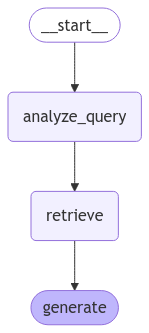

In [24]:
from IPython.display import Image, display

# 그래프의 구조를 Mermaid 다이어그램으로 출력합니다.
display(Image(app.get_graph().draw_mermaid_png()))

**구현 테스트하기**

이제 게시물의 **시작 부분**, **중간 부분**, **끝 부분**에서 문맥을 가져오도록 명확하게 요청하여 우리의 구현을 테스트해 볼 수 있습니다.  

모델의 답변에 **다른 정보가 포함될 것**임을 확인할 수 있습니다.

In [25]:
for step in app.stream(
    {"question": "게시물의 시작 부분에서는 **Task Decomposition**에 대해 뭐라고 언급하나요?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'Task Decomposition', 'section': '시작 부분'}}}

----------------

{'retrieve': {'context': [Document(id='58468f93-e48d-4c77-bfe0-c94b5a70b424', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2192, 'section': '시작 부분'}, page_content='Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.\nTask decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.'), Document(id='341419bb-d65d-41d1-bb5c-6a

In [26]:
for step in app.stream(
    {"question": "게시물의 중간 부분에서는 **Task Decomposition**에 대해 뭐라고 언급하나요?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'Task Decomposition', 'section': '중간 부분'}}}

----------------

{'retrieve': {'context': [Document(id='af00d466-3cb5-4fda-b732-1d3bd021d647', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 17413, 'section': '중간 부분'}, page_content='Fig. 11. Illustration of how HuggingGPT works. (Image source: Shen et al. 2023)\nThe system comprises of 4 stages:\n(1) Task planning: LLM works as the brain and parses the user requests into multiple tasks. There are four attributes associated with each task: task type, ID, dependencies, and arguments. They use few-shot examples to guide LLM to do task parsing and planning.\nInstruction:'), Document(id='e779f602-48ef-45e9-a85f-94ac208e8fab', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 29629, 'section': '중간 부분'}, page_content='Resources:\n1. Internet access for searches and information gathering.\n2. Long Term memory management.\n3. 

In [27]:
for step in app.stream(
    {"question": "게시물의 끝 부분에서는 **Task Decomposition**에 대해 뭐라고 언급하나요?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'Task Decomposition', 'section': '끝 부분'}}}

----------------

{'retrieve': {'context': [Document(id='33c6fff4-9c9b-4cca-a7fd-85634d77e75e', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 32069, 'section': '끝 부분'}, page_content='},\n  {\n    "role": "user",\n    "content": "{{There are 10 levels in total. The main character is a plumber named Mario, who can walk and jump. It is a classical platform game just like Super Mario. The main character moves from left to right, trying to get to the destination, where there are many obstacles and attacks from enemies in the process.}}\\n\\nIs anything else unclear? If yes, only answer in the form:\\n{remaining unclear areas} remaining questions.\\n{Next question}\\nIf everything is sufficiently clear, only answer \\"Nothing more to clarify.\\"."\n  },\n  {\n    "role": "assistant",\n    "content": "Remaining unclear areas: 2 remaining questions.\\nCan you provide m

**스트리밍 단계(Streamed Steps)** 와 [**LangSmith 추적(LangSmith Trace)**](https://smith.langchain.com/public/bdbaae61-130c-4338-8b59-9315dfee22a0/r)에서 이제 **검색 단계(Retrieval Step)** 에 입력된 **구조화된 쿼리(Structured Query)** 를 확인할 수 있습니다.  